### Process Tiff Stack

In [1]:
from pvd_par import PVD

In [2]:
# Set paths
data_path = '/S:/pvd_data/DataSet04/'
worm = 'expDS4_02'
tiff_stack_path = f"{data_path}{worm}/{worm}.tif"

output_dir = 'output/'

# Old test worm
tiff_stack_path = 'A:/Git Repos/worm-warp/stacks/exp240202_01_E.tif'

In [8]:
# Execute pipeline
pvd = PVD(tiff_stack_path)
pvd.run_pipeline()

Starting pipeline
Loaded raw data with shape: (4, 89, 2048, 2048)
Completed preprocessing timepoint 3
Completed preprocessing timepoint 0
Completed preprocessing timepoint 2
Completed preprocessing timepoint 1
Skeletonizing timepoint 0
Skeletonizing timepoint 1
Skeletonizing timepoint 2
Skeletonizing timepoint 3
Completed skeletonizing timepoint 0
Completed skeletonizing timepoint 1
Completed skeletonizing timepoint 3
Completed skeletonizing timepoint 2
Skeletonized data shape: [(89, 2048, 2048), (89, 2048, 2048), (89, 2048, 2048), (89, 2048, 2048)]
Number of tips per timepoint: [120, 52, 40, 60]
Number of knots per timepoint: [177, 75, 58, 77]
Pipeline completed


In [4]:
#pvd.save_results(output_dir, save_tiff=True)

### Visualize

In [5]:
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.io as pio
import numpy as np

timepoint = 2

# Prepare skeleton data for plotting
image_stack = np.transpose(pvd.skeletonized_data[timepoint], (1, 2, 0))
x, y, z = image_stack.shape
Y, X, Z = np.meshgrid(np.arange(y), np.arange(x), np.arange(z))
colors = image_stack.ravel()

# Extract background points
visible_mask = colors != 0

# Extract coordinates for skeleton tips
tips_z = [point[0] for point in pvd.tips[timepoint]]
tips_x = [point[1] for point in pvd.tips[timepoint]]
tips_y = [point[2] for point in pvd.tips[timepoint]]

# Extract coordinates for skeleton knots
knot_z = [point[0] for point in pvd.knots[timepoint]]
knot_x = [point[1] for point in pvd.knots[timepoint]]
knot_y = [point[2] for point in pvd.knots[timepoint]]

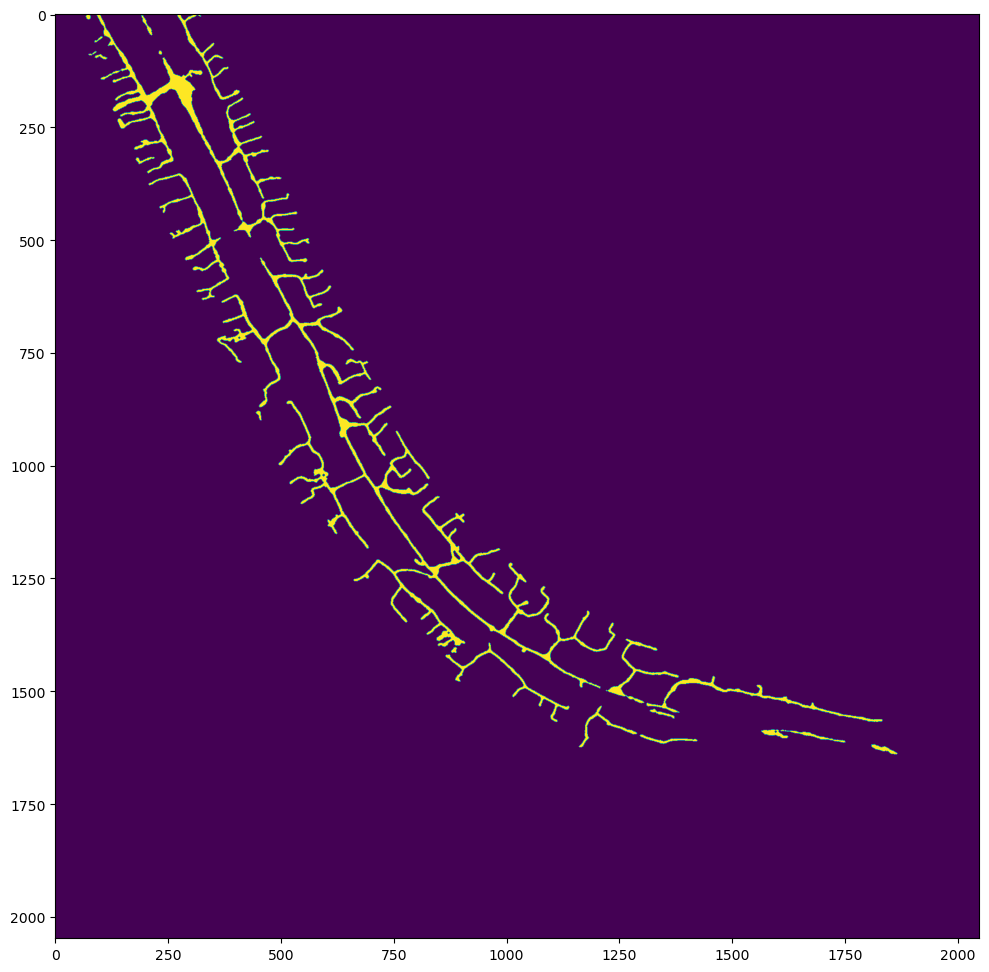

In [6]:
# Check out MIP Mask for timepoint
fig, ax = plt.subplots(figsize=(12, 12))
ax.imshow(pvd.mip_masks[timepoint].astype(np.uint8))

In [7]:
# Plot
fig = go.Figure()

# Skeleton tips
fig.add_trace(go.Scatter3d(
    x=tips_x,
    y=tips_y,
    z=tips_z,
    mode='markers',  # Use 'lines' for a line plot or 'markers+lines' for both
    marker=dict(
        size=5,
        color='red',  # You can customize the color
        opacity=.9
    )
))

# Skeleton knots
fig.add_trace(go.Scatter3d(
    x=knot_x,
    y=knot_y,
    z=knot_z,
    mode='markers',  # Use 'lines' for a line plot or 'markers+lines' for both
    marker=dict(
        size=4,
        color='blue',  # You can customize the color
        opacity=.9
    )
))

# Skeleton structure
fig.add_trace(go.Scatter3d(
    x=X.ravel()[visible_mask],
    y=Y.ravel()[visible_mask],
    z=Z.ravel()[visible_mask],
    mode='markers',
    marker=dict(
        size=2,
        color='black',
        colorscale='Viridis',
        opacity=.1
    )
))

# Update layout
fig.update_layout(
    title=f"C. Elegans PVD Neuron: {worm} \n Timepoint: {timepoint}",
    scene=dict(
        xaxis_title='X (pixels)',
        yaxis_title='Y (pixels)',
        zaxis_title='Z (image index)',
        aspectmode='manual',
        aspectratio=dict(x=1, y=1, z=.1),  # Adjust z-axis scale if desired
        zaxis=dict(range=[0, pvd.skeletonized_data[timepoint].shape[0]]),  # Set z-axis bounds
        xaxis=dict(range=[0, pvd.skeletonized_data[timepoint].shape[1]]),  # Set x-axis bounds
        yaxis=dict(range=[0, pvd.skeletonized_data[timepoint].shape[2]]),  # Set y-axis bounds

    ),
    autosize=True

)

# Show the figure
#fig.show()